# Terzaghi 1D Consolidation (Single Drainage): Uniform IC 
## Analytical Fourier Series vs FEM (FEniCSx)

This notebook verifies a 1D single-layer FEniCSx solution of Terzaghi’s consolidation (diffusion) equation for excess pore pressure against a truncated Fourier-series analytical reference for the standard uniform initial condition.

## Model + methods
- Layer thickness (H); 1D vertical flow.
- Single drainage BCs. (u(0,t)=0) (drained top), (du/dz (H,t)=0) (impermeable base).
- FEM: weak form on a 1D mesh, time integration via Backward Euler.

## Error metrics + convergence
At each time step, FEM is compared to the analytical solution using:
- RMSE over depth
- Normalised (L^2) error over time or whole dimensions.

Convergence studies:
- Mesh refinement (error vs mesh size)
- Time-step refinement (error vs (time step number), including log–log plots)

## Notes
- Early time errors are typically larger due to steep near boundary gradients. Coarse meshes or/and small time steps can exaggerate error. Analytical accuracy depends on Fourier truncation (N terms number), whereas FEM accuracy depends on spatial and temporal resolution.
- Error calculations have been done in local degree of consolidation rather than pore pressure. For future verifications checks these will be done using pore pressure.



In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



# set up to allow juypter notebook to use local modulse from src 
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.insert(0, module_path)

from terazaghi_1d.fea_fenicsx import Get_Terazaghi1D_FEA 
from terazaghi_1d.analytical import Get_Terazaghi1d_Analytical


# parameters 
H = 5
num = 50
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 1000
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 200

total_settlement = Mv*P*H

print("\nModel parameters used for analytical and FEM solutions:")
print("--------------------------------------------------------")
print(f"Layer thickness,             = {H:.2f} m")
print(f"Applied surface pressure,    = {P:.2f} kPa")
print(f"Simulation duration,         = {Tx/(60*60*24):.2f} days")
print(f"Number of time steps         = {time_step}")
print(f"Time step size               = {(dt/(60*60*24)):.2f} days")
print(f"Coefficient of consolidation = {Cv:.2e} m^2/s")
print(f"Coefficient of volume comp.  = {Mv:.2e} m^2/kN\n")
print(f"Number of elements (FEM)     = {num}")
print(f"Number of nodes (FEM)        = {nodes}\n")
print(f"Analytical series terms      = {N_terms}\n")
print(f"Dimensionless time factor    = {time_factor:.4f}")
print(f"Total Settlement             = {total_settlement:.4f} m")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Model parameters used for analytical and FEM solutions:
--------------------------------------------------------
Layer thickness,             = 5.00 m
Applied surface pressure,    = 100.00 kPa
Simulation duration,         = 365.00 days
Number of time steps         = 1000
Time step size               = 0.36 days
Coefficient of consolidation = 2.00e-07 m^2/s
Coefficient of volume comp.  = 5.00e-04 m^2/kN

Number of elements (FEM)     = 50
Number of nodes (FEM)        = 51

Analytical series terms      = 200

Dimensionless time factor    = 0.0003
Total Settlement             = 0.2500 m


# FEniCSx Solver
Single Layered FEnicsx Solver, showing outputted local degree of consolidation solution.

In [36]:
# plotting fenicsx data. to note purposely choicen different t or time_step+1 as fenicsx gives t+1 results due to uh ands 
fem_cdata = Get_Terazaghi1D_FEA(H, num, P, Tx, time_step, Cv, 0, True) # 0 as we are using uniform force 
Z = -np.linspace(0, H, num = nodes)
T = np.linspace(0,(Tx/(60*60*24)), num= time_step)
fem_cdata = pd.DataFrame(fem_cdata, columns = Z, index = T)

fem_cdata

,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.365365,1.0,0.348798,0.089544,0.022988,0.005901,0.001515,0.000389,0.000100,0.000026,0.000007,...,-4.440892e-16,-4.440892e-16,-2.220446e-16,-2.220446e-16,1.110223e-16,0.000000e+00,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16
0.730731,1.0,0.503981,0.201338,0.070160,0.022754,0.007059,0.002125,0.000626,0.000181,0.000052,...,-6.661338e-16,-6.661338e-16,-6.661338e-16,-4.440892e-16,-2.220446e-16,-4.440892e-16,-2.220446e-16,-2.220446e-16,-6.661338e-16,-6.661338e-16
1.096096,1.0,0.588915,0.291248,0.125570,0.049089,0.017907,0.006210,0.002073,0.000672,0.000212,...,-8.881784e-16,-8.881784e-16,-8.881784e-16,-6.661338e-16,-2.220446e-16,-4.440892e-16,-4.440892e-16,-6.661338e-16,-6.661338e-16,-6.661338e-16
1.461461,1.0,0.642644,0.360235,0.178946,0.080528,0.033520,0.013124,0.004894,0.001755,0.000609,...,-1.110223e-15,-1.332268e-15,-8.881784e-16,-8.881784e-16,-2.220446e-16,-4.440892e-16,-4.440892e-16,-6.661338e-16,-8.881784e-16,-1.110223e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,1.0,0.978332,0.956687,0.935087,0.913555,0.892112,0.870782,0.849586,0.828547,0.807685,...,3.432970e-01,3.377284e-01,3.328041e-01,3.285282e-01,3.249041e-01,3.219349e-01,3.196230e-01,3.179703e-01,3.169782e-01,3.166474e-01
363.903904,1.0,0.978346,0.956716,0.935130,0.913611,0.892183,0.870867,0.849685,0.828659,0.807811,...,3.437006e-01,3.381350e-01,3.332133e-01,3.289396e-01,3.253174e-01,3.223498e-01,3.200391e-01,3.183872e-01,3.173956e-01,3.170649e-01
364.269269,1.0,0.978361,0.956744,0.935172,0.913668,0.892254,0.870952,0.849783,0.828771,0.807937,...,3.441041e-01,3.385414e-01,3.336223e-01,3.293508e-01,3.257305e-01,3.227644e-01,3.204549e-01,3.188039e-01,3.178127e-01,3.174823e-01
364.634635,1.0,0.978375,0.956772,0.935215,0.913725,0.892324,0.871036,0.849882,0.828883,0.808062,...,3.445073e-01,3.389475e-01,3.340310e-01,3.297617e-01,3.261433e-01,3.231788e-01,3.208705e-01,3.192203e-01,3.182297e-01,3.178994e-01


# Analytical Solver
Showing outputted local degree of consolidation solution.

In [37]:
# analytical solution plotitng 
analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, time_step, num, Cv, N_terms)
a_T = np.linspace(0, Tx/(60*60*24), time_step, dtype=float)
analytical_cdata = pd.DataFrame(analytical_cdata, columns= -a_Z, index= a_T)

analytical_cdata

,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,1.0,0.050069,0.025268,0.016888,0.012689,0.010169,8.490676e-03,7.294024e-03,6.398483e-03,5.703780e-03,...,1.657345e-03,1.643161e-03,1.630814e-03,1.620238e-03,1.611378e-03,1.604189e-03,1.598634e-03,1.594686e-03,1.592325e-03,1.591539e-03
0.365365,1.0,0.373511,0.075103,0.007591,0.000371,0.000009,9.320261e-08,4.681703e-10,1.084910e-12,1.221245e-15,...,-2.220446e-16,-6.661338e-16,0.000000e+00,-4.440892e-16,6.661338e-16,-1.332268e-15,-4.440892e-16,-1.332268e-15,5.551115e-16,-2.220446e-16
0.730731,1.0,0.529175,0.208199,0.059053,0.011834,0.001653,1.596245e-04,1.058503e-05,4.800236e-07,1.484058e-08,...,-4.440892e-16,-2.220446e-16,7.771561e-16,1.110223e-16,-2.220446e-16,-1.110223e-15,-8.881784e-16,-1.776357e-15,-8.881784e-16,1.110223e-16
1.096096,1.0,0.607396,0.304144,0.123224,0.039862,0.010200,2.050888e-03,3.224579e-04,3.950598e-05,3.761489e-06,...,1.110223e-16,5.551115e-16,6.661338e-16,-2.220446e-16,2.220446e-16,-1.110223e-15,-1.110223e-15,-1.110223e-15,-2.220446e-16,-2.220446e-16
1.461461,1.0,0.656350,0.373511,0.181917,0.075103,0.026095,7.590760e-03,1.841264e-03,3.713246e-04,6.211569e-05,...,-2.220446e-16,1.110223e-16,0.000000e+00,-8.881784e-16,5.551115e-16,-1.332268e-15,-2.220446e-16,-1.332268e-15,1.110223e-16,-2.220446e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,1.0,0.978335,0.956693,0.935096,0.913566,0.892126,8.707990e-01,8.496058e-01,8.285688e-01,8.077096e-01,...,3.433249e-01,3.377555e-01,3.328305e-01,3.285539e-01,3.249292e-01,3.219596e-01,3.196473e-01,3.179943e-01,3.170020e-01,3.166711e-01
363.903904,1.0,0.978349,0.956721,0.935138,0.913623,0.892197,8.708837e-01,8.497044e-01,8.286810e-01,8.078354e-01,...,3.437287e-01,3.381623e-01,3.332398e-01,3.289654e-01,3.253427e-01,3.223745e-01,3.200634e-01,3.184113e-01,3.174195e-01,3.170888e-01
364.269269,1.0,0.978364,0.956750,0.935181,0.913680,0.892268,8.709684e-01,8.498028e-01,8.287932e-01,8.079610e-01,...,3.441323e-01,3.385688e-01,3.336489e-01,3.293767e-01,3.257559e-01,3.227893e-01,3.204794e-01,3.188281e-01,3.178368e-01,3.175063e-01
364.634635,1.0,0.978378,0.956778,0.935224,0.913736,0.892339,8.710530e-01,8.499012e-01,8.289052e-01,8.080865e-01,...,3.445356e-01,3.389750e-01,3.340578e-01,3.297878e-01,3.261689e-01,3.232038e-01,3.208951e-01,3.192447e-01,3.182539e-01,3.179236e-01


# Computing for Error (RMSE & L2)


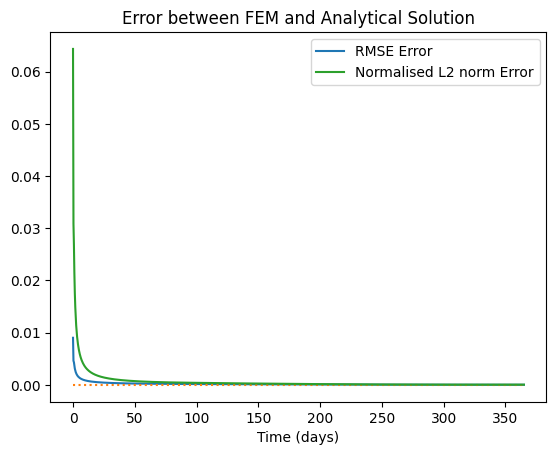

In [38]:
# assumes that the t and z for both data is identical in which it is 
error = fem_cdata - analytical_cdata
#RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))
# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (analytical_cdata**2).sum(axis = 1)
E_L2 = np.sqrt(num / (den+ 1e-12))
time = np.linspace(0, (Tx/(60*60*24)), time_step)


# plotting err
plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot([0,np.max(time)],[0,0], linestyle ="dotted")  # Please change for capture of map
plt.plot(time, E_L2, label = "Normalised L2 norm Error")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Error between FEM and Analytical Solution")
plt.show()


# Settlement Plots

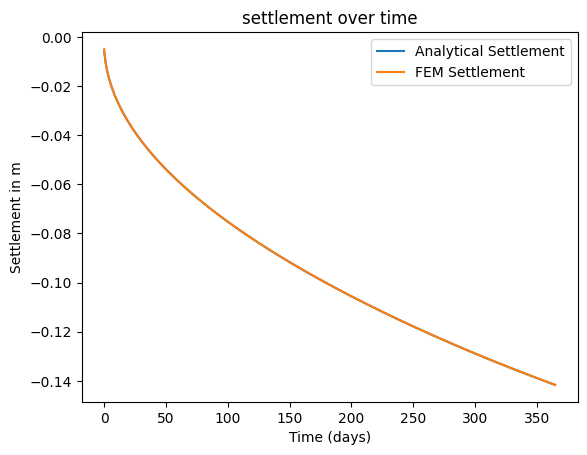

total settlement: 0.25 m
total consolidation settlement reach. 
analytical: 0.1417m 
FEM: 0.1416m 
actual total settlememt: 0.25 


In [39]:

# drawing settlement with time plotting 
analytical_settlement= analytical_cdata.mean(axis=1)*total_settlement
fem_settlement = fem_cdata.mean(axis=1)*total_settlement

plt.figure()
plt.plot(time, -analytical_settlement, label="Analytical Settlement")
plt.plot(time, -fem_settlement, label="FEM Settlement")
plt.xlabel("Time (days)")
plt.ylabel("Settlement in m")
plt.legend()
plt.title("settlement over time")
plt.show()
print(f"total settlement: {total_settlement} m")

print(f"total consolidation settlement reach. \nanalytical: {np.max(analytical_settlement):.4f}m \nFEM: {np.max(fem_settlement):.4}m \nactual total settlememt: {total_settlement:.4} ")

# Heat Map Representation through out time 
note: these use local degree of consolidation and not settlement

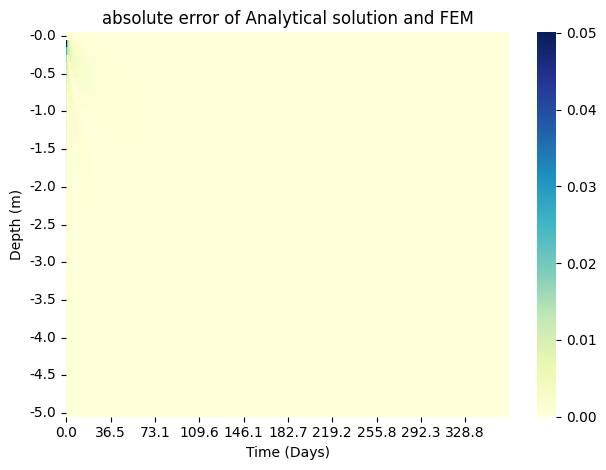

In [40]:
time = time
depth = Z

kx = max(1, len(time)//10)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 


ax = sns.heatmap(abs(error).T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)

ax.set_xlabel("Time (Days)")
ax.set_ylabel("Depth (m)")
ax.set_title("absolute error of Analytical solution and FEM")
plt.tight_layout()
plt.show()




## Mesh and time-step convergence

To ensure the analytical reference remains sufficiently accurate for fine discretisations, the Fourier series truncation was increased (from 200 to 400 terms). As the mesh is refined, the time step is also reduced to avoid temporal error dominating the spatial convergence results (fine meshes are more sensitive to (time steps numbers)).

Some early-time error remains due to sharp near-boundary gradients and Fourier truncation effects, but the overall trend should show decreasing error with refinement.


In [41]:
mesh_size = [10,25,50, 100, 200] # add in 100 and 200
time_step = [40,250,1000, 4000, 16000] # add in 4000 and 16000
 

N_terms = 400

mesh_size = np.array(mesh_size, dtype = int)
time_step = np.array(time_step, dtype = int)
RMSE_mesh = []
L2_mesh = []

for nx, timestep in zip(mesh_size,time_step):
    fem_cdata = Get_Terazaghi1D_FEA(H, nx, P, Tx, timestep, Cv, 0, True) 
    analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, timestep, nx, Cv, N_terms)

    error = fem_cdata - analytical_cdata
    RMSE = np.sqrt(np.mean(error**2))  
    RMSE_mesh = np.append(RMSE_mesh, RMSE)  

    num = (error**2).sum(axis = 1)
    den = (analytical_cdata**2).sum(axis = 1)
    E_L2 = np.mean(np.sqrt(num / (den+ 1e-30)), axis = 0) 
    
    L2_mesh = np.append(L2_mesh,E_L2)
    

    print(f"nx: {nx} RMSE: {RMSE}, L2: {E_L2}")



/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:126: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


nx: 10 RMSE: 0.0038637630286619063, L2: 0.006993490012743869
nx: 25 RMSE: 0.001080655342759314, L2: 0.0018471460390060963
nx: 50 RMSE: 0.00041348896028401197, L2: 0.0006163339255122587
nx: 100 RMSE: 0.00017242951728010844, L2: 0.00019739500032668473
nx: 200 RMSE: 8.627396416062831e-05, L2: 6.208448876701725e-05


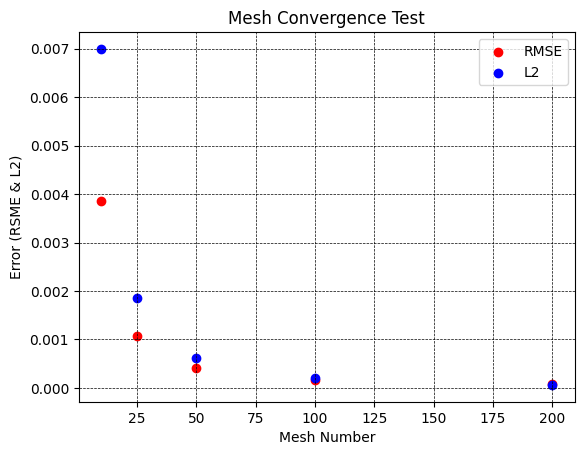

L2 plot: 0.28x^-1.580996, R^2 = 0.99909
RMSE plot: 0.07x^-1.282746, R^2 = 0.99610


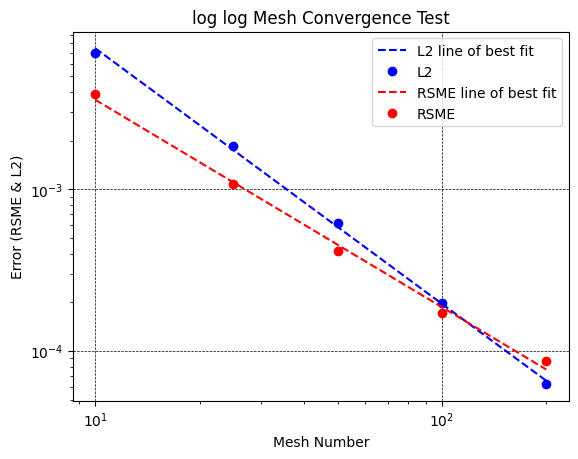

In [44]:
# raw scatter plotting 
plt.scatter(mesh_size, RMSE_mesh, label = "RMSE", color = "r")
plt.scatter(mesh_size, L2_mesh, label = "L2", color = "b")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5",)
plt.xlabel("Mesh Number")
plt.ylabel("Error (RSME & L2)")
plt.title("Mesh Convergence Test")
plt.legend()
plt.show()



# linear regression for L2 for mesh
x_L2 = np.log(mesh_size)
y_L2 = np.log(L2_mesh)
p_L2, logC_L2 = np.polyfit(x_L2,y_L2, 1)
C_L2 = np.exp(logC_L2) 
Y_linearL2 = C_L2 * mesh_size**p_L2
# R2 
yhat_L2 = p_L2*x_L2 + logC_L2
ss_res_L2 = np.sum((y_L2 - yhat_L2)**2)
ss_tot_L2 = np.sum((y_L2 - y_L2.mean())**2)
r2_L2 = 1 - ss_res_L2/ss_tot_L2


# linear regression for RMSE for mesh
x_RMSE = np.log(mesh_size)
y_RMSE = np.log(RMSE_mesh)
p_RMSE, logC_RMSE = np.polyfit(x_RMSE,y_RMSE, 1)
C_RMSE = np.exp(logC_RMSE) 
Y_linearRMSE = C_RMSE * mesh_size**p_RMSE 
# R2 
yhat_RMSE = p_RMSE*x_L2 + logC_RMSE
ss_res_RMSE = np.sum((y_RMSE - yhat_RMSE)**2)
ss_tot_RMSE = np.sum((y_RMSE - y_RMSE.mean())**2)
r2_RMSE = 1 - ss_res_RMSE/ss_tot_RMSE

print(f"L2 plot: {C_L2:.2f}x^{p_L2:2f}, R^2 = {r2_L2:.5f}")

print(f"RMSE plot: {C_RMSE:.2f}x^{p_RMSE:2f}, R^2 = {r2_RMSE:.5f}")

plt.loglog(mesh_size, Y_linearL2, linestyle = "--", label= f"L2 line of best fit", color = "b")
plt.loglog(mesh_size,L2_mesh, linestyle = "None", marker = "o", label = 'L2', color = "b")

plt.loglog(mesh_size, Y_linearRMSE,linestyle = "--", label= f"RSME line of best fit", color = "r")
plt.loglog(mesh_size, RMSE_mesh, linestyle = "None", marker = "o", label = "RSME", color = "r")

plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("Mesh Number")
plt.ylabel("Error (RSME & L2)")
plt.title("log log Mesh Convergence Test")
plt.legend()
plt.show()


In [45]:
# parameters redefine because their a mix up in paramters before
H = 5
num = 50
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 1000
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

# n terms for analitical solution 
N_terms = 400


time_step = [100,200,400,800,1600, 3200]

time_step = np.array(time_step)
RMSE_timeint = []
L2_timeint = []


for i in time_step:
    fem_cdata = Get_Terazaghi1D_FEA(H, num, P, Tx, i, Cv, 0, True) 
    analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, i, num, Cv, N_terms)

    error = fem_cdata - analytical_cdata
    RMSE_timeinst = np.sqrt(np.mean(error**2))  
    RMSE_timeint = np.append(RMSE_timeint, RMSE_timeinst)

    num_sq = (error**2).sum(axis=1)
    den_sq = (analytical_cdata**2).sum(axis=1)
    E_L2 = np.mean(np.sqrt(num_sq / (den_sq + 1e-30)), axis=0)
    L2_timeint = np.append(L2_timeint,E_L2)

    print(f"for {i} time intervals, RMSE: {RMSE_timeinst}, L2: ")

/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:126: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


for 100 time intervals, RMSE: 0.00444690717704185, L2: 
for 200 time intervals, RMSE: 0.002507636300604272, L2: 
for 400 time intervals, RMSE: 0.0013060985247999566, L2: 
for 800 time intervals, RMSE: 0.0005728901972681896, L2: 
for 1600 time intervals, RMSE: 0.00022426544609410978, L2: 
for 3200 time intervals, RMSE: 0.0003179795245774301, L2: 


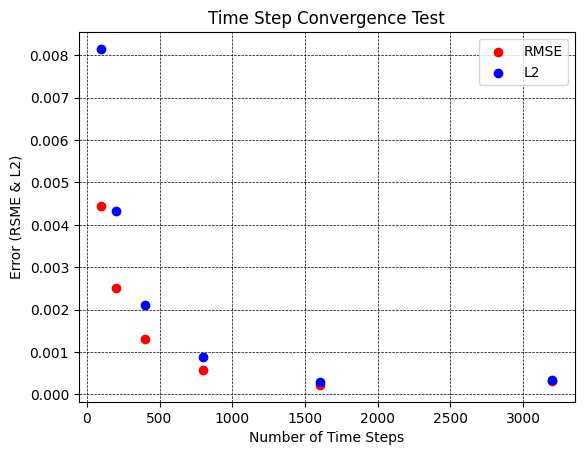

L2 plot: 0.90*x^-1.023673, R^2 = 0.95542
RMSE plot: 0.24*x^-0.876202, R^2 = 0.92796


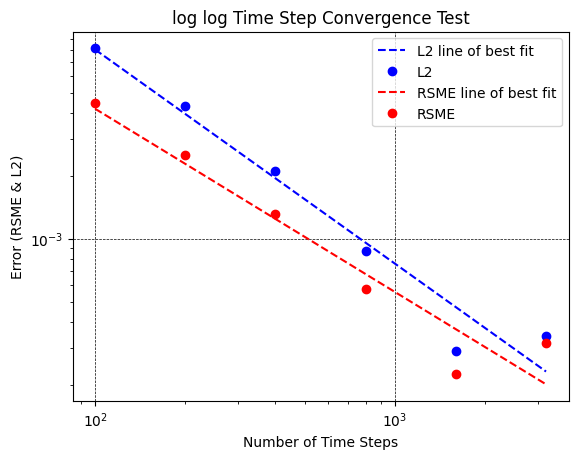

In [46]:
# raw scatter plotting 
plt.scatter(time_step, RMSE_timeint, label = "RMSE", color = "r")
plt.scatter(time_step, L2_timeint, label = "L2", color = "b")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5",)
plt.xlabel("Number of Time Steps")
plt.ylabel("Error (RSME & L2)")
plt.title("Time Step Convergence Test")
plt.legend()
plt.show()




# linear regression for L2 for mesh
x_L2 = np.log(time_step)
y_L2 = np.log(L2_timeint)
p_L2, logC_L2 = np.polyfit(x_L2,y_L2, 1)
C_L2 = np.exp(logC_L2) 
Y_linearL2 = C_L2 * time_step**p_L2
# R2 
yhat_L2 = p_L2*x_L2 + logC_L2
ss_res_L2 = np.sum((y_L2 - yhat_L2)**2)
ss_tot_L2 = np.sum((y_L2 - y_L2.mean())**2)
r2_L2 = 1 - ss_res_L2/ss_tot_L2


# linear regression for RMSE for mesh
x_RMSE = np.log(time_step)
y_RMSE = np.log(RMSE_timeint)
p_RMSE, logC_RMSE = np.polyfit(x_RMSE,y_RMSE, 1)
C_RMSE = np.exp(logC_RMSE) 
Y_linearRMSE = C_RMSE * time_step**p_RMSE 
# R2 
yhat_RMSE = p_RMSE*x_L2 + logC_RMSE
ss_res_RMSE = np.sum((y_RMSE - yhat_RMSE)**2)
ss_tot_RMSE = np.sum((y_RMSE - y_RMSE.mean())**2)
r2_RMSE = 1 - ss_res_RMSE/ss_tot_RMSE

print(f"L2 plot: {C_L2:.2f}*x^{p_L2:2f}, R^2 = {r2_L2:.5f}")

print(f"RMSE plot: {C_RMSE:.2f}*x^{p_RMSE:2f}, R^2 = {r2_RMSE:.5f}")

plt.loglog(time_step, Y_linearL2, linestyle = "--", label= f"L2 line of best fit", color = "b")
plt.loglog(time_step,L2_timeint, linestyle = "None", marker = "o", label = 'L2', color = "b")

plt.loglog(time_step, Y_linearRMSE,linestyle = "--", label= f"RSME line of best fit", color = "r")
plt.loglog(time_step, RMSE_timeint, linestyle = "None", marker = "o", label = "RSME", color = "r")

plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("Number of Time Steps")
plt.ylabel("Error (RSME & L2)")
plt.title("log log Time Step Convergence Test")
plt.legend()
plt.show()
